# Impor Packages

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os
os.getcwd()
from operator import attrgetter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Import data dari csv ke Dataframe

In [ ]:
df = pd.read_csv('Salinan Online Retail Data.csv', header=0)
df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


# Data Cleansing

In [ ]:
df_clean = df.copy()
# mengkonversi kolom order_date menjadi datetime
df_clean['order_date'] = df_clean['order_date'].astype('datetime64[ns]')
# membuat kolom year_month
df_clean['year_month'] = df_clean['order_date'].dt.to_period('M')
# menghapus semua baris tanpa customer_id
df_clean = df_clean[~df_clean['customer_id'].isna()]
# menghapus semua baris tanpa product_name
df_clean = df_clean[~df_clean['product_name'].isna()]
# membuat semua product_name berhuruf kecil
df_clean['product_name'] = df_clean['product_name'].str.lower()
# menghapus semua baris dengan product_code atau product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]
# membuat kolom order_status dengan nilai 'cancelled' jika order_id diawali dengan huruf 'c' dan 'delivered' jika order_id tanpa awalan huruf 'c'
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')
# mengubah nilai quantity yang negatif menjadi positif karena nilai negatif tersebut hanya menandakan order tersebut cancelled
df_clean['quantity'] = df_clean['quantity'].abs()
# menghapus baris dengan price bernilai negatif
df_clean = df_clean[df_clean['price']>0]
# membuat nilai amount, yaitu perkalian antara quantity dan price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']
# mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')
# mengkonversi customer_id menjadi string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)
# menghapus outlier
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean.head()

<ipython-input-35-562641c376ec>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['amount'] = df_clean['quantity'] * df_clean['price']


,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01,cancelled,4.25
1,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,91.80
2,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,51.00
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,5.10
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,8.50


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358469 entries, 0 to 358468
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      358469 non-null  object        
 1   product_code  358469 non-null  object        
 2   product_name  358469 non-null  object        
 3   quantity      358469 non-null  int64         
 4   order_date    358469 non-null  datetime64[ns]
 5   price         358469 non-null  float64       
 6   customer_id   358469 non-null  object        
 7   year_month    358469 non-null  period[M]     
 8   order_status  358469 non-null  object        
 9   amount        358469 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), period[M](1)
memory usage: 27.3+ MB


# Membuat user retention cohort

## Agregat data transaksi ke bentuk summary total transaksi/order setiap pengguna setiap bulan

In [ ]:
df_user_monthly = df_clean.groupby(['customer_id', 'year_month'], as_index=False).agg(order_cnt=('order_id', 'nunique'))
df_user_monthly

,customer_id,year_month,order_cnt
0,12346.0,2010-01,1
1,12346.0,2010-03,1
2,12346.0,2010-06,2
3,12346.0,2010-10,1
4,12608.0,2010-10,1
...,...,...,...
12039,18286.0,2010-06,1
12040,18286.0,2010-08,1
12041,18287.0,2010-05,1
12042,18287.0,2010-09,2


## Buat kolom sebagai cohort dari pengguna, misal cohort bulan pertama kali bertransaksi

In [ ]:
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')
df_user_monthly

,customer_id,year_month,order_cnt,cohort
0,12346.0,2010-01,1,2010-01
1,12346.0,2010-03,1,2010-01
2,12346.0,2010-06,2,2010-01
3,12346.0,2010-10,1,2010-01
4,12608.0,2010-10,1,2010-10
...,...,...,...,...
12039,18286.0,2010-06,1,2010-06
12040,18286.0,2010-08,1,2010-06
12041,18287.0,2010-05,1,2010-05
12042,18287.0,2010-09,2,2010-05


## Hitung jarak bulan antara bulan transaksi dengan bulan pertama kali transaksi dan jumlahkan dengan 1 agar jarak bulan 0 menjadi 1 yang berarti bulan pertama, dst.

In [ ]:
df_user_monthly['period_num'] = (df_user_monthly['year_month'] - df_user_monthly['cohort']).apply(attrgetter('n')) + 1
df_user_monthly

,customer_id,year_month,order_cnt,cohort,period_num
0,12346.0,2010-01,1,2010-01,1
1,12346.0,2010-03,1,2010-01,3
2,12346.0,2010-06,2,2010-01,6
3,12346.0,2010-10,1,2010-01,10
4,12608.0,2010-10,1,2010-10,1
...,...,...,...,...,...
12039,18286.0,2010-06,1,2010-06,1
12040,18286.0,2010-08,1,2010-06,3
12041,18287.0,2010-05,1,2010-05,1
12042,18287.0,2010-09,2,2010-05,5


## Tabel pivot dengan index berupa cohort, kolom berupa jarak bulan, dan nilainya adalah banyaknya pengguna unik (count unique dari ID pengguna)

In [ ]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,713.0,280.0,334.0,313.0,305.0,304.0,293.0,268.0,285.0,319.0,335.0,249.0
2010-02,461.0,154.0,128.0,161.0,152.0,121.0,119.0,159.0,153.0,166.0,100.0,NaN
2010-03,528.0,146.0,158.0,145.0,140.0,123.0,149.0,186.0,193.0,96.0,NaN,NaN
2010-04,326.0,82.0,75.0,63.0,69.0,79.0,98.0,101.0,50.0,NaN,NaN,NaN
2010-05,274.0,55.0,50.0,52.0,52.0,72.0,67.0,43.0,NaN,NaN,NaN,NaN
2010-06,266.0,53.0,56.0,60.0,65.0,85.0,39.0,NaN,NaN,NaN,NaN,NaN
2010-07,179.0,38.0,37.0,52.0,53.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,160.0,35.0,50.0,48.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,227.0,64.0,60.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Hitung banyaknya pengguna di masing-masing cohort (pengguna yang pertama kali transaksi di bulan tersebut) dan bagi semua nilai di tabel pivot tadi dengan nilai tersebut sebagai retention rate

In [ ]:
cohort_size = df_cohort_pivot.iloc[:, 0]
cohort_size

cohort
2010-01    713.0
2010-02    461.0
2010-03    528.0
2010-04    326.0
2010-05    274.0
2010-06    266.0
2010-07    179.0
2010-08    160.0
2010-09    227.0
2010-10    362.0
2010-11    327.0
2010-12     66.0
Freq: M, Name: 1, dtype: float64

In [ ]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,1.0,0.392707,0.468443,0.438990,0.427770,0.426367,0.410940,0.375877,0.399719,0.447405,0.469846,0.349229
2010-02,1.0,0.334056,0.277657,0.349241,0.329718,0.262473,0.258134,0.344902,0.331887,0.360087,0.216920,NaN
2010-03,1.0,0.276515,0.299242,0.274621,0.265152,0.232955,0.282197,0.352273,0.365530,0.181818,NaN,NaN
2010-04,1.0,0.251534,0.230061,0.193252,0.211656,0.242331,0.300613,0.309816,0.153374,NaN,NaN,NaN
2010-05,1.0,0.200730,0.182482,0.189781,0.189781,0.262774,0.244526,0.156934,NaN,NaN,NaN,NaN
2010-06,1.0,0.199248,0.210526,0.225564,0.244361,0.319549,0.146617,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.212291,0.206704,0.290503,0.296089,0.167598,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.218750,0.312500,0.300000,0.168750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.281938,0.264317,0.136564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Tampilkan tabel pivot yang sudah berisi nilai retention rate tersebut dalam heatmap

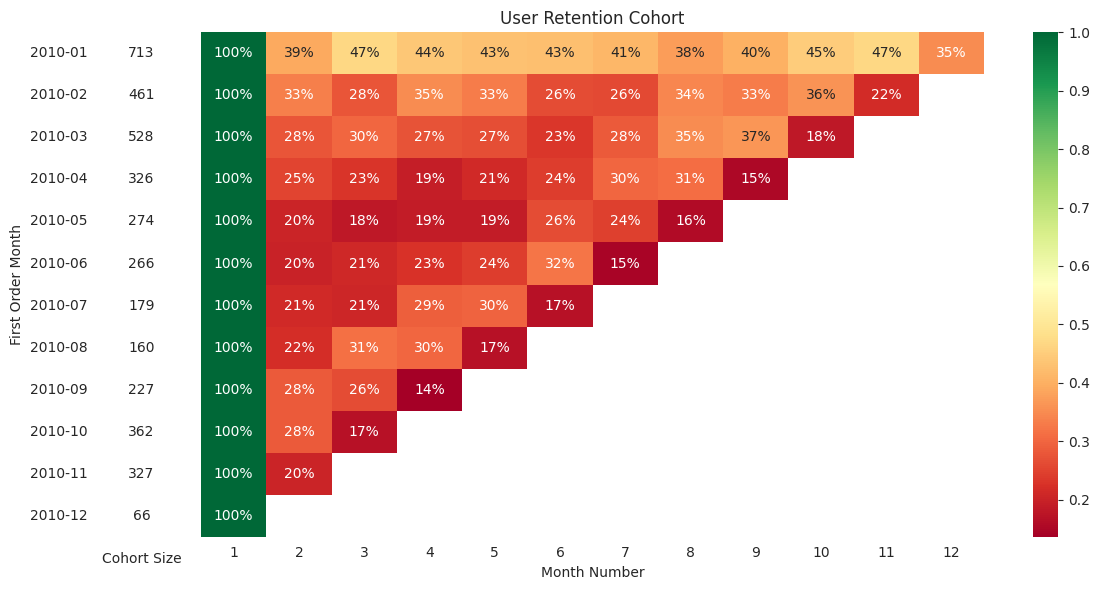

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors

# Misalnya df_retention_cohort dan cohort_size adalah dataframe yang telah didefinisikan sebelumnya
# df_retention_cohort = ...
# cohort_size = ...

with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # User retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Month Number', ylabel='')

    # Cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_camp = mcolors.ListedColormap(['White'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_camp, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

#plt.show()
fig.tight_layout()